In [1]:
import numpy as np
import matplotlib.pyplot as plt

from activation_classifier import ActivationClassifier

import torch
import hypernetx as hnx
import networkx as nx

from models.hypergraph_models import HyperGCN, MyHyperGCN, HyperResidGCN

from train_utils import train_eval_loop, get_activations
from vis_utils import plot_activations_by_class, plot_cluster_activations
from graph_utils import get_local_hypergraph, plot_samples

from load_coraca import get_coraca_hypergraph

# Cora Coauthorship hypergraph

In [3]:
hgraph_coraca = get_coraca_hypergraph()
num_classes = 7

In [4]:
print(hgraph_coraca.H.shape)
print(hgraph_coraca.H)

torch.Size([2708, 3780])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [5]:
print(hgraph_coraca.incidence_dict.keys())
print(hgraph_coraca.incidence_dict.values())

dict_keys(['e0', 'e1', 'e10', 'e100', 'e1000', 'e1001', 'e1002', 'e1003', 'e1004', 'e1005', 'e1006', 'e1007', 'e1008', 'e1009', 'e101', 'e1010', 'e1011', 'e1012', 'e1013', 'e1014', 'e1015', 'e1016', 'e1017', 'e1018', 'e1019', 'e102', 'e1020', 'e1021', 'e1022', 'e1023', 'e1024', 'e1025', 'e1026', 'e1027', 'e1028', 'e1029', 'e103', 'e1030', 'e1031', 'e1032', 'e1033', 'e1034', 'e1035', 'e1036', 'e1037', 'e1038', 'e1039', 'e104', 'e1040', 'e1041', 'e1042', 'e1043', 'e1044', 'e1045', 'e1046', 'e1047', 'e1048', 'e1049', 'e105', 'e1050', 'e1051', 'e1052', 'e1053', 'e1054', 'e1055', 'e1056', 'e1057', 'e1058', 'e1059', 'e106', 'e1060', 'e1061', 'e1062', 'e1063', 'e1064', 'e1065', 'e1066', 'e1067', 'e1068', 'e1069', 'e107', 'e1070', 'e1071', 'e108', 'e109', 'e11', 'e110', 'e111', 'e112', 'e113', 'e114', 'e115', 'e116', 'e117', 'e118', 'e119', 'e12', 'e120', 'e121', 'e122', 'e123', 'e124', 'e125', 'e126', 'e127', 'e128', 'e129', 'e13', 'e130', 'e131', 'e132', 'e133', 'e134', 'e135', 'e136', 'e137

In [6]:
print(hgraph_coraca.edge_index.shape)
print(hgraph_coraca.edge_index)

torch.Size([2, 7293])
tensor([[   0,    0,    1,  ..., 2706, 2707, 2707],
        [1048, 1072,  780,  ..., 2970,  986, 2971]])


In [7]:
print(hgraph_coraca)
print(hgraph_coraca.shape)
print(hgraph_coraca.x.shape)
print(hgraph_coraca.y.shape)
print(hgraph_coraca.H.shape)
print(hgraph_coraca.edge_index.shape)

Cora Co-Authorship, <class 'hypernetx.classes.hypergraph.Hypergraph'>
(2708, 3780)
torch.Size([2708, 1433])
torch.Size([2708])
torch.Size([2708, 3780])
torch.Size([2, 7293])


# Device

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
def put_hgraph_attributes_on_device(hgraph, device) -> None:
    hgraph.train_mask = hgraph.train_mask.to(device)
    hgraph.val_mask = hgraph.val_mask.to(device)
    hgraph.test_mask = hgraph.test_mask.to(device)
    hgraph.x = hgraph.x.to(device)
    hgraph.y = hgraph.y.to(device)
    hgraph.H = hgraph.H.to(device)
    hgraph.edge_index = hgraph.edge_index.to(device)

# GCN

In [9]:
put_hgraph_attributes_on_device(hgraph_coraca, device)

In [12]:
model_gcn = HyperGCN(input_dim=hgraph_coraca.x.shape[1], hidden_dim=128, output_dim=num_classes, num_layers=2, use_attention=False)
model_gcn.to(device)

train_stats_cocora = train_eval_loop(
    model=model_gcn,
    hgraph=hgraph_coraca,
    train_mask=hgraph_coraca.train_mask,
    val_mask=hgraph_coraca.val_mask,
    test_mask=hgraph_coraca.test_mask,
    lr=0.01,
    num_epochs=100,
)

Epoch 0 with train loss: 1.946 train acc: 0.314 val acc: 0.294
Epoch 10 with train loss: 1.549 train acc: 0.352 val acc: 0.318
Epoch 20 with train loss: 1.038 train acc: 0.728 val acc: 0.659
Epoch 30 with train loss: 0.575 train acc: 0.875 val acc: 0.799
Epoch 40 with train loss: 0.326 train acc: 0.921 val acc: 0.848
Epoch 50 with train loss: 0.211 train acc: 0.939 val acc: 0.846
Epoch 60 with train loss: 0.147 train acc: 0.957 val acc: 0.835
Epoch 70 with train loss: 0.108 train acc: 0.973 val acc: 0.838
Epoch 80 with train loss: 0.084 train acc: 0.983 val acc: 0.839
Epoch 90 with train loss: 0.066 train acc: 0.989 val acc: 0.830
Final test acc: 0.789


# GAT

In [13]:
put_hgraph_attributes_on_device(hgraph_coraca, torch.device('cpu'))

In [14]:
model_gat = HyperGCN(input_dim=hgraph_coraca.x.shape[1], hidden_dim=128, output_dim=num_classes, num_layers=2, use_attention=True)

train_stats_cocora = train_eval_loop(
    model=model_gat,
    hgraph=hgraph_coraca,
    train_mask=hgraph_coraca.train_mask,
    val_mask=hgraph_coraca.val_mask,
    test_mask=hgraph_coraca.test_mask,
    lr=0.01,
    num_epochs=50,
)

x.shape=torch.Size([2708, 1433])
edge_index.shape=torch.Size([2, 7293])
edge_feat.shape=torch.Size([3780, 1433])


RuntimeError: index 3003 is out of bounds for dimension 0 with size 2708

# GCN (using my conv layer)

In [15]:
model_gcn_my = MyHyperGCN(input_dim=1433, output_dim=num_classes, hidden_dim=128, num_layers=2)
model_gcn_my.to(device)
put_hgraph_attributes_on_device(hgraph_coraca, device)

train_stats_cocora = train_eval_loop(
    model=model_gcn_my,
    hgraph=hgraph_coraca,
    train_mask=hgraph_coraca.train_mask,
    val_mask=hgraph_coraca.val_mask,
    test_mask=hgraph_coraca.test_mask,
    lr=0.01,
    num_epochs=50,
)

Epoch 0 with train loss: 1.961 train acc: 0.094 val acc: 0.102
Epoch 10 with train loss: 1.697 train acc: 0.313 val acc: 0.294
Epoch 20 with train loss: 1.334 train acc: 0.658 val acc: 0.569
Epoch 30 with train loss: 0.862 train acc: 0.790 val acc: 0.722
Epoch 40 with train loss: 0.515 train acc: 0.888 val acc: 0.812
Final test acc: 0.777


# Deep-HGCN (residual connect)

In [16]:
model_gcn_resid = HyperResidGCN(input_dim=1433, output_dim=num_classes, hidden_dim=32, num_layers=2, alpha=0.1, beta=0.1)
model_gcn_resid.to(device)

train_stats_cocora = train_eval_loop(
    model=model_gcn_resid,
    hgraph=hgraph_coraca,
    train_mask=hgraph_coraca.train_mask,
    val_mask=hgraph_coraca.val_mask,
    test_mask=hgraph_coraca.test_mask,
    lr=0.01,
    num_epochs=100,
)

Epoch 0 with train loss: 1.942 train acc: 0.306 val acc: 0.297
Epoch 10 with train loss: 1.779 train acc: 0.313 val acc: 0.294
Epoch 20 with train loss: 1.548 train acc: 0.368 val acc: 0.347
Epoch 30 with train loss: 1.229 train acc: 0.466 val acc: 0.433
Epoch 40 with train loss: 0.862 train acc: 0.645 val acc: 0.588
Epoch 50 with train loss: 0.538 train acc: 0.816 val acc: 0.713
Epoch 60 with train loss: 0.289 train acc: 0.922 val acc: 0.761
Epoch 70 with train loss: 0.148 train acc: 0.964 val acc: 0.753
Epoch 80 with train loss: 0.072 train acc: 0.986 val acc: 0.744
Epoch 90 with train loss: 0.035 train acc: 0.996 val acc: 0.739
Final test acc: 0.700


In [140]:
model_gcn_resid = HyperResidGCN(input_dim=1433, output_dim=num_classes, hidden_dim=32, num_layers=2, alpha=0.1, beta=0.1, dropout=0.5)
model_gcn_resid.to(device)

train_stats_cocora = train_eval_loop(
    model=model_gcn_resid,
    hgraph=hgraph_coraca,
    train_mask=hgraph_coraca.train_mask,
    val_mask=hgraph_coraca.val_mask,
    test_mask=hgraph_coraca.test_mask,
    lr=0.01,
    num_epochs=100,
)

Epoch 0 with train loss: 1.963 train acc: 0.075 val acc: 0.078
Epoch 10 with train loss: 1.832 train acc: 0.313 val acc: 0.294
Epoch 20 with train loss: 1.717 train acc: 0.313 val acc: 0.294
Epoch 30 with train loss: 1.428 train acc: 0.442 val acc: 0.412
Epoch 40 with train loss: 1.162 train acc: 0.598 val acc: 0.576
Epoch 50 with train loss: 0.878 train acc: 0.700 val acc: 0.635
Epoch 60 with train loss: 0.660 train acc: 0.832 val acc: 0.712
Epoch 70 with train loss: 0.553 train acc: 0.865 val acc: 0.730
Epoch 80 with train loss: 0.489 train acc: 0.900 val acc: 0.722
Epoch 90 with train loss: 0.393 train acc: 0.908 val acc: 0.731
Final test acc: 0.690


In [142]:
model_gcn_resid = HyperResidGCN(input_dim=1433, output_dim=num_classes, hidden_dim=32, num_layers=4, alpha=0.5, beta=0.1, dropout=0.5)
model_gcn_resid.to(device)

train_stats_cocora = train_eval_loop(
    model=model_gcn_resid,
    hgraph=hgraph_coraca,
    train_mask=hgraph_coraca.train_mask,
    val_mask=hgraph_coraca.val_mask,
    test_mask=hgraph_coraca.test_mask,
    lr=0.01,
    num_epochs=100,
)

Epoch 0 with train loss: 1.942 train acc: 0.118 val acc: 0.100
Epoch 10 with train loss: 1.827 train acc: 0.313 val acc: 0.294
Epoch 20 with train loss: 1.668 train acc: 0.315 val acc: 0.294
Epoch 30 with train loss: 1.337 train acc: 0.484 val acc: 0.434
Epoch 40 with train loss: 0.967 train acc: 0.745 val acc: 0.619
Epoch 50 with train loss: 0.620 train acc: 0.840 val acc: 0.687
Epoch 60 with train loss: 0.424 train acc: 0.894 val acc: 0.721
Epoch 70 with train loss: 0.319 train acc: 0.931 val acc: 0.730
Epoch 80 with train loss: 0.218 train acc: 0.939 val acc: 0.743
Epoch 90 with train loss: 0.179 train acc: 0.993 val acc: 0.747
Final test acc: 0.739


In [144]:
model_gcn_resid = HyperResidGCN(input_dim=1433, output_dim=num_classes, hidden_dim=32, num_layers=8, alpha=0.5, beta=0.1, dropout=0.5)
model_gcn_resid.to(device)

train_stats_cocora = train_eval_loop(
    model=model_gcn_resid,
    hgraph=hgraph_coraca,
    train_mask=hgraph_coraca.train_mask,
    val_mask=hgraph_coraca.val_mask,
    test_mask=hgraph_coraca.test_mask,
    lr=0.01,
    num_epochs=100,
)

Epoch 0 with train loss: 1.964 train acc: 0.160 val acc: 0.167
Epoch 10 with train loss: 1.825 train acc: 0.313 val acc: 0.294
Epoch 20 with train loss: 1.634 train acc: 0.317 val acc: 0.295
Epoch 30 with train loss: 1.167 train acc: 0.671 val acc: 0.594
Epoch 40 with train loss: 0.871 train acc: 0.716 val acc: 0.622
Epoch 50 with train loss: 0.664 train acc: 0.788 val acc: 0.657
Epoch 60 with train loss: 0.524 train acc: 0.866 val acc: 0.674
Epoch 70 with train loss: 0.382 train acc: 0.906 val acc: 0.694
Epoch 80 with train loss: 0.293 train acc: 0.928 val acc: 0.710
Epoch 90 with train loss: 0.244 train acc: 0.937 val acc: 0.716
Final test acc: 0.688


# Activations - basic GCN

In [17]:
model_coraca = model_gcn

In [18]:
activations_coraca = {}

model_coraca.gcn_layers[0].register_forward_hook(get_activations('conv0', activations_coraca))
model_coraca.gcn_layers[1].register_forward_hook(get_activations('conv1', activations_coraca))

In [19]:
model_coraca.eval()
with torch.no_grad():
    out = model_coraca(hgraph_coraca)

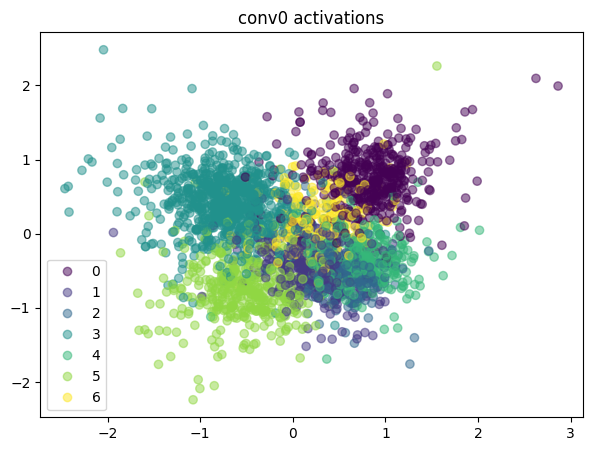

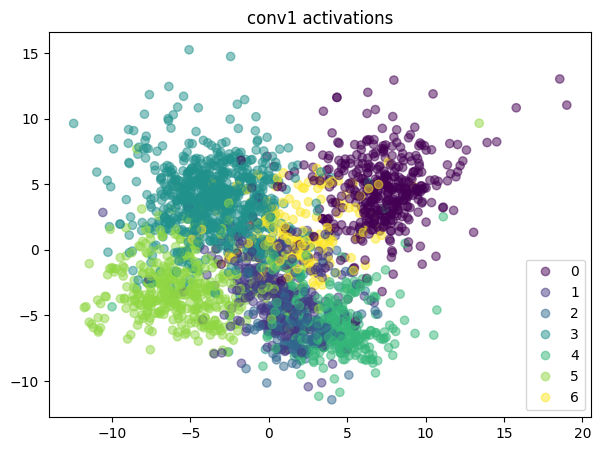

In [20]:
plot_activations_by_class(activations_coraca, hgraph_coraca.y)

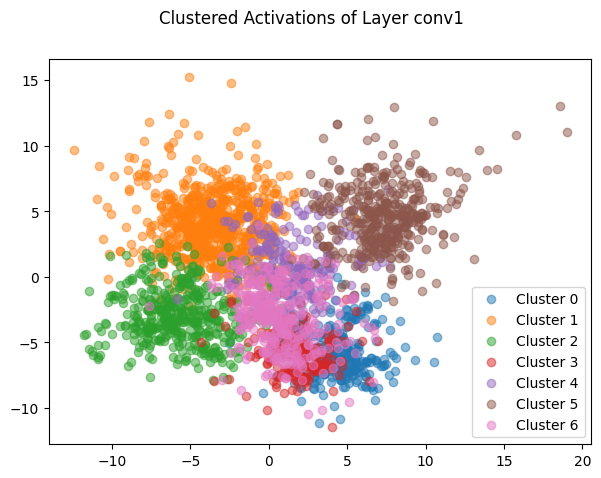

In [30]:
activ, kmeans_model = plot_cluster_activations(activations_coraca, 'conv1', num_clusters=7)

# Activations - residual GCN

In [119]:
model_gcn_resid

HyperResidGCN(
  (fc_in): Linear(in_features=1433, out_features=32, bias=True)
  (hnn_layers): ModuleList(
    (0): MyHypergraphConvResid(
      (Linear): Linear(in_features=32, out_features=32, bias=True)
    )
    (1): MyHypergraphConvResid(
      (Linear): Linear(in_features=32, out_features=32, bias=True)
    )
    (2): MyHypergraphConvResid(
      (Linear): Linear(in_features=32, out_features=32, bias=True)
    )
    (3): MyHypergraphConvResid(
      (Linear): Linear(in_features=32, out_features=32, bias=True)
    )
    (4): MyHypergraphConvResid(
      (Linear): Linear(in_features=32, out_features=32, bias=True)
    )
    (5): MyHypergraphConvResid(
      (Linear): Linear(in_features=32, out_features=32, bias=True)
    )
    (6): MyHypergraphConvResid(
      (Linear): Linear(in_features=32, out_features=32, bias=True)
    )
    (7): MyHypergraphConvResid(
      (Linear): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (fc_out): Linear(in_features=32, out_features=7

In [120]:
activations_gcnresid = {}

model_gcn_resid.hnn_layers[0].register_forward_hook(get_activations('conv0', activations_gcnresid))
model_gcn_resid.hnn_layers[1].register_forward_hook(get_activations('conv1', activations_gcnresid))
model_gcn_resid.fc_out.register_forward_hook(get_activations('fc_out', activations_gcnresid))

model_gcn_resid.eval()
with torch.no_grad():
    out = model_gcn_resid(hgraph_coraca)

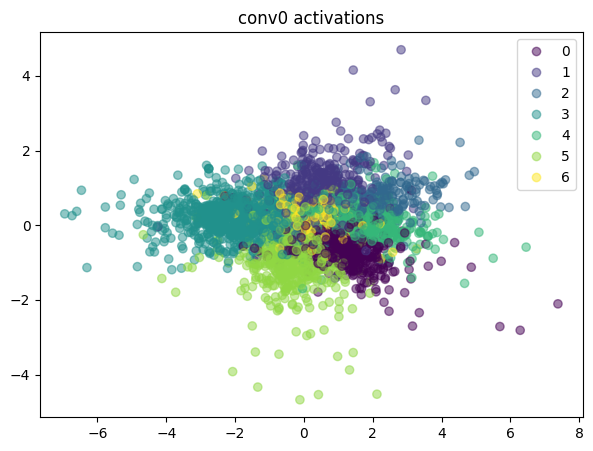

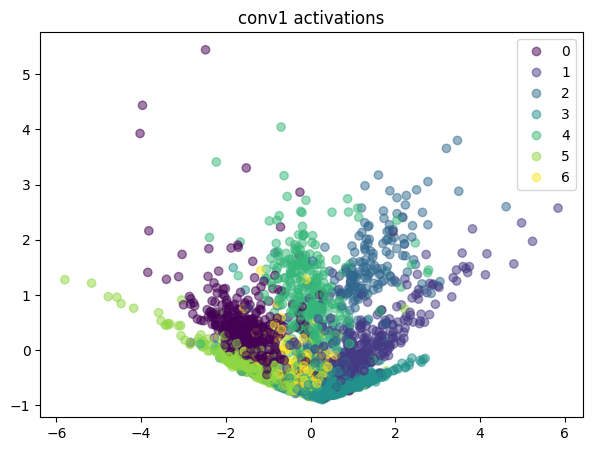

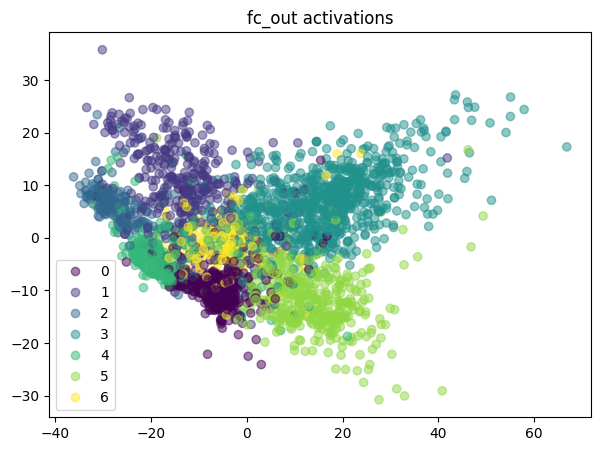

In [121]:
plot_activations_by_class(activations_gcnresid, hgraph_coraca.y)

# Show concepts

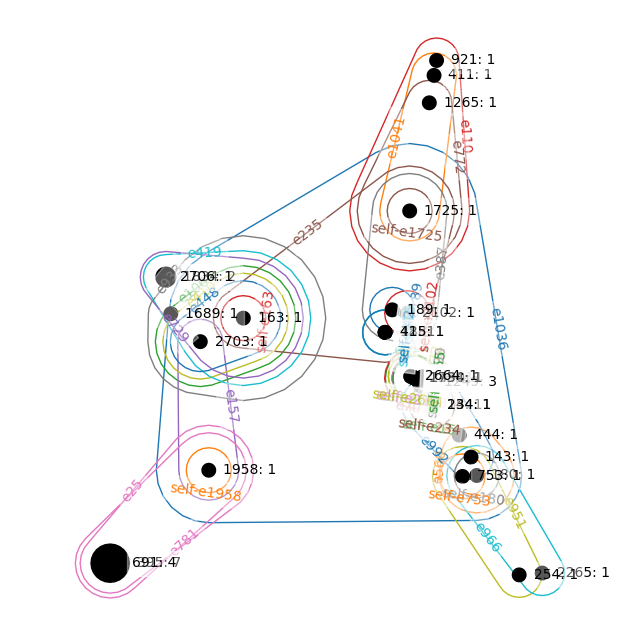

In [28]:
# view neighbours of arbitrary node
foo = get_local_hypergraph(42, hgraph_coraca, num_expansions=2)
hnx.draw(foo.collapse_nodes(), layout=nx.spectral_layout)

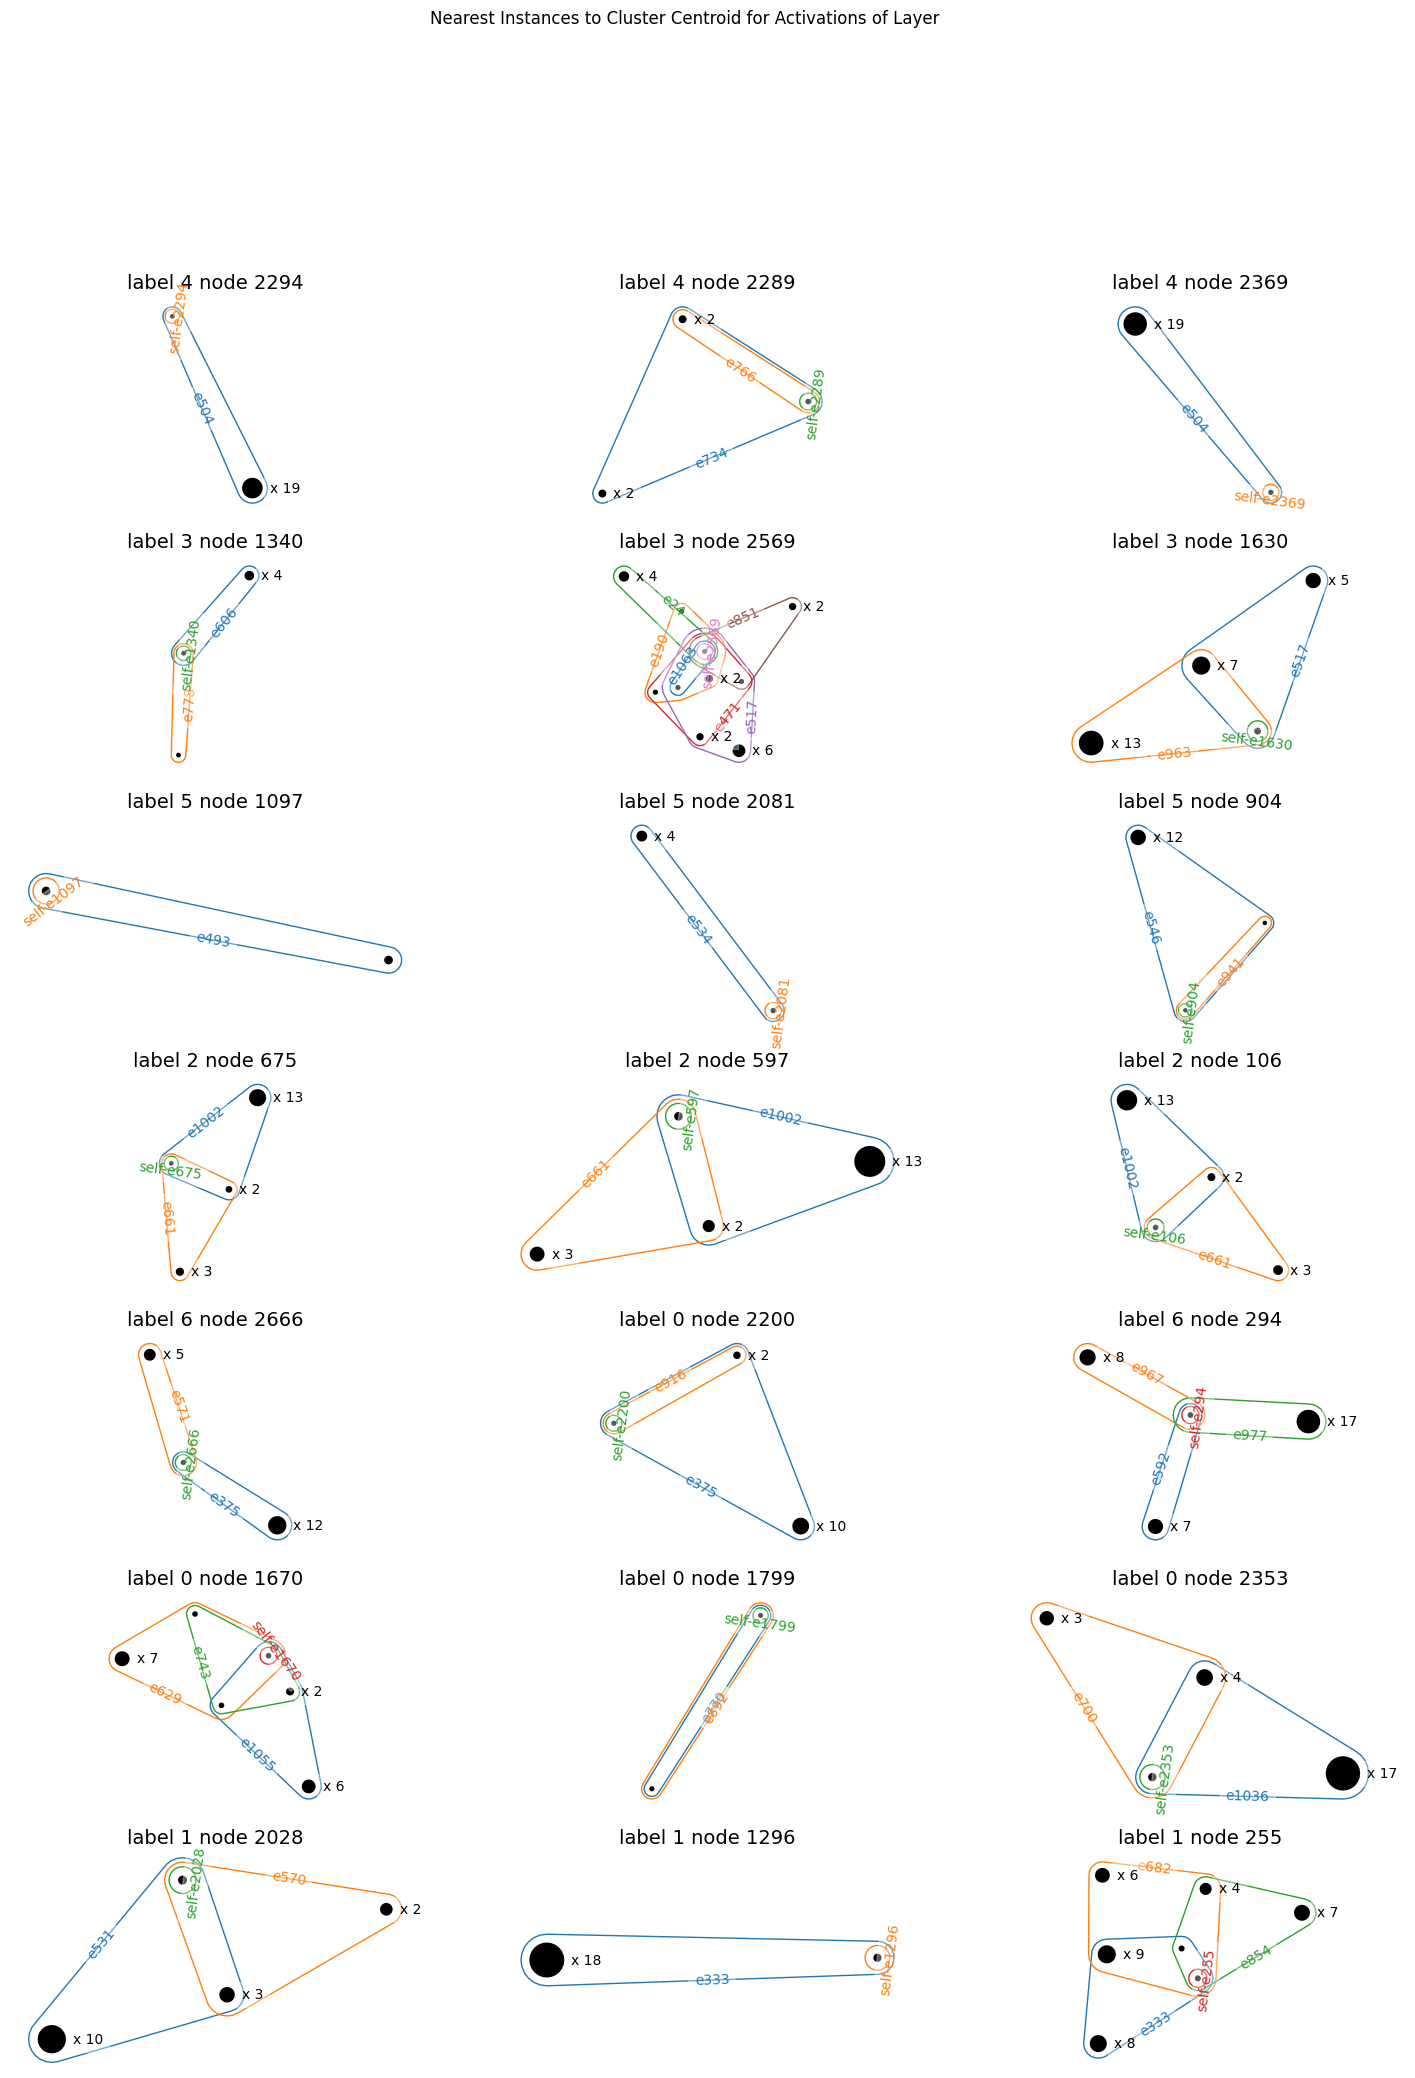

In [34]:
sample_graphs, sample_feats = plot_samples(activ, kmeans_model, hgraph_coraca.y, hgraph_coraca, num_expansions=1, num_nodes_view=3)

# Concept completeness

In [31]:
ac = ActivationClassifier(
    activ, kmeans_model, "decision_tree",
    hgraph_coraca.x.cpu(), hgraph_coraca.y.cpu(), 
    hgraph_coraca.train_mask.cpu(), hgraph_coraca.test_mask.cpu())

In [32]:
ac.get_classifier_accuracy()

0.793205317577548

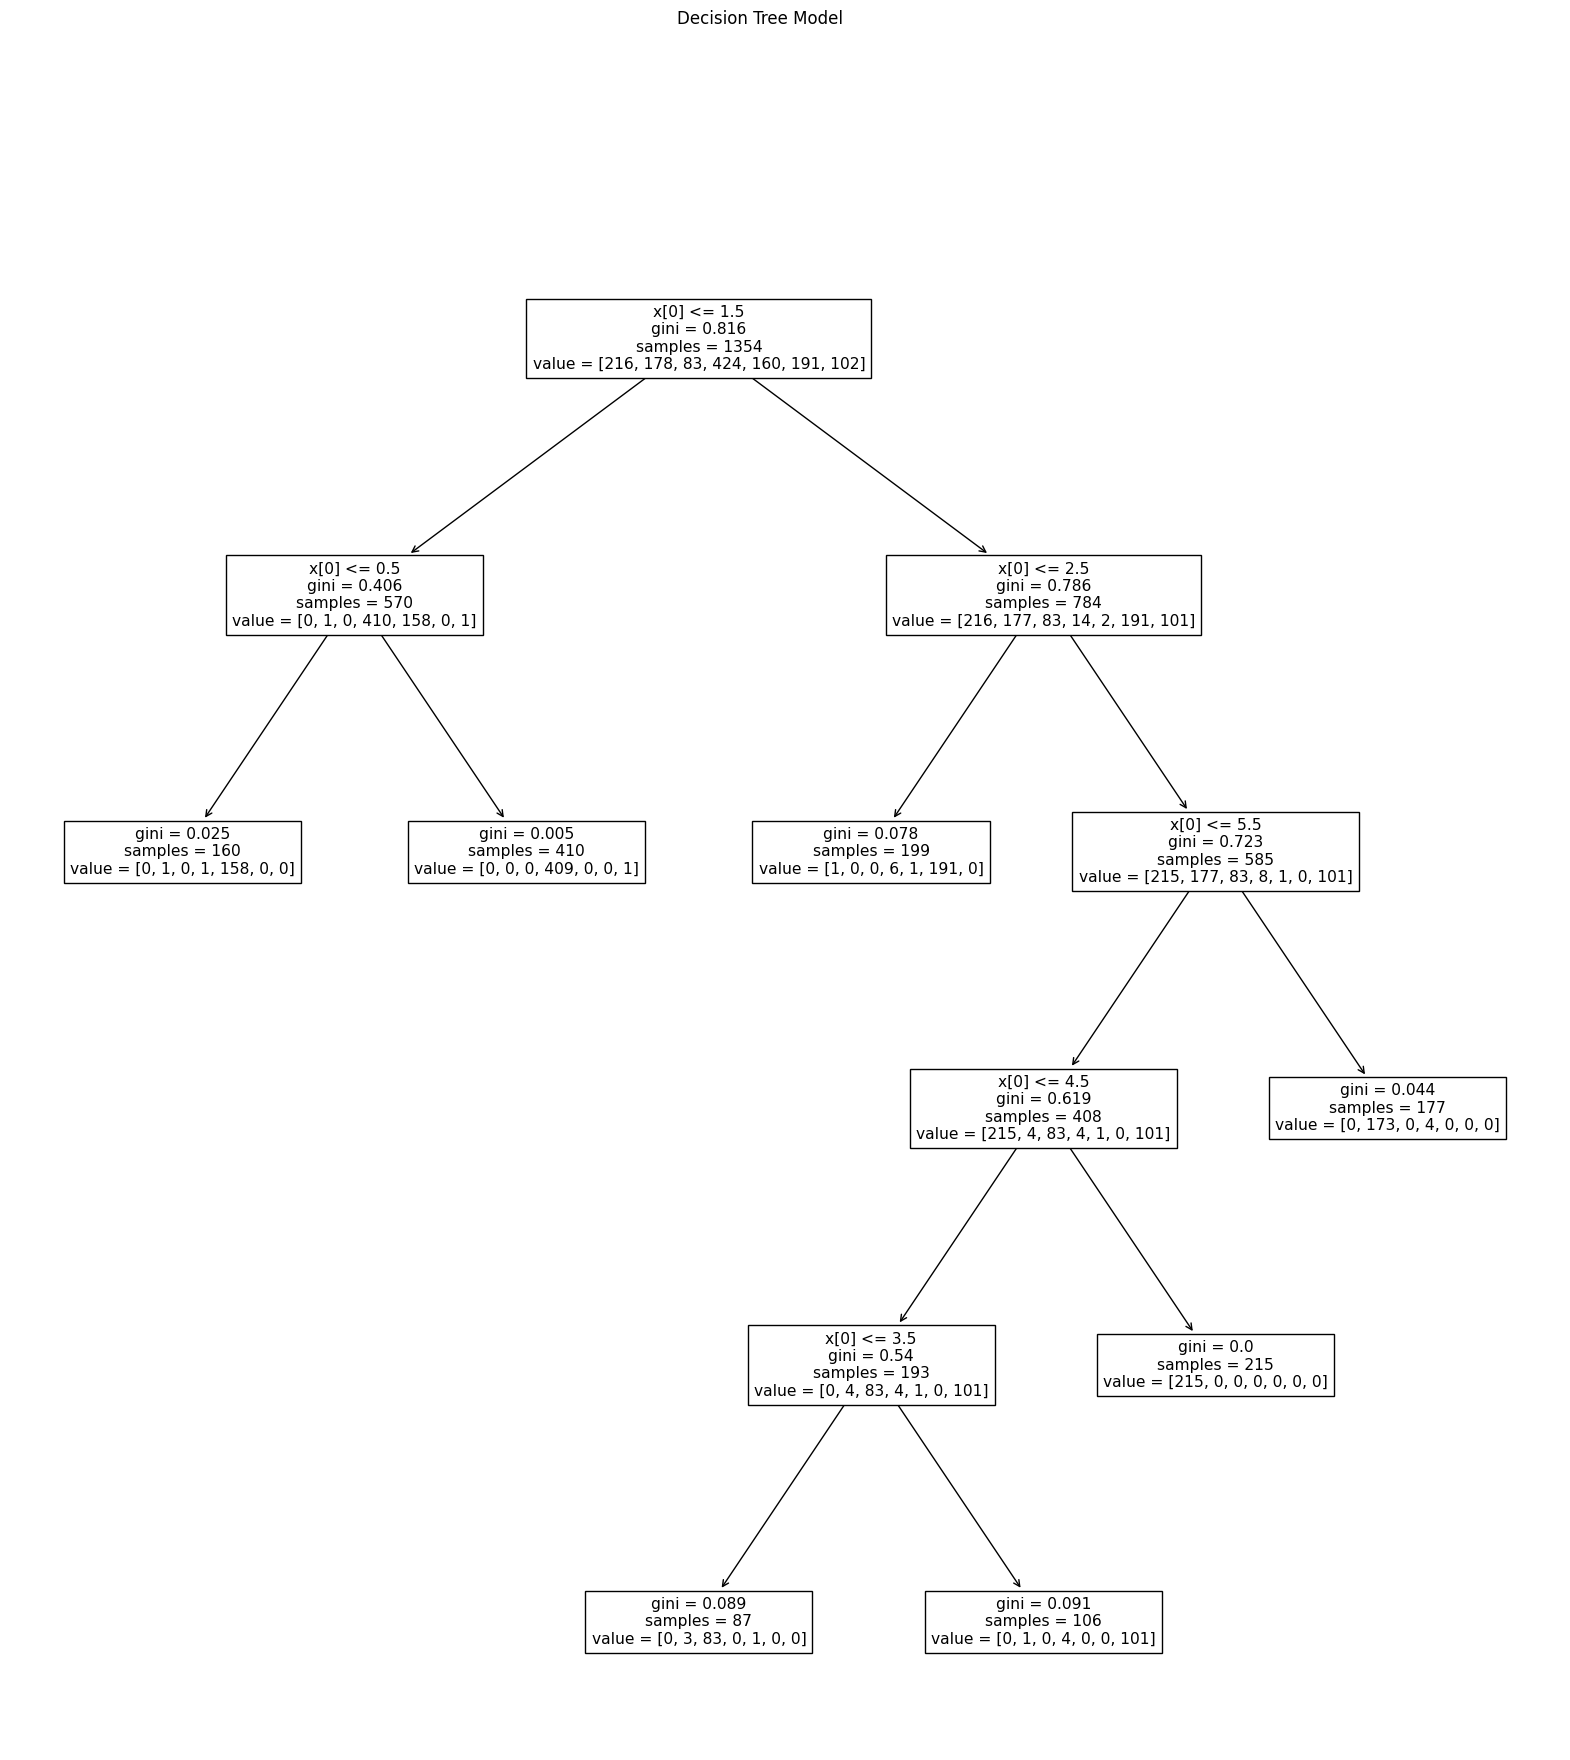

In [33]:
ac.plot('figures', 'clustered_activs_decisiontree')